# Map, Reduce, and Multiprocessing

Multiprocessing capabilities can be an effective tool for speeding up a time-consuming workflow by making it possible to execute portions of the workflow in parallel across multiple CPU cores. However, for more complex workflows, data and control flow dependencies that can lead to race conditions can make implementation, debugging, and maintenance more challenging.

One approach to consider when planning a new workflow is whether the workflow is amenable to a more functional implementation that leverages *map* and *reduce* operations (*i.e.,* whether it is compatible with the [MapReduce](https://en.wikipedia.org/wiki/MapReduce) paradigm). In practice, many common workflows that can be parallelized are also possible to implement in this paradigm. If this fits your workflow, you can take advantage of this to make your use multiprocessing solution simpler, more elegant, and easier to maintain.

## Example Workflow with Map and Reduce

Because Python supports the functional programming paradigm and has built-in [`map`](https://docs.python.org/3/library/functions.html#map) and [`reduce`](https://docs.python.org/3/library/functools.html#functools.reduce) functions, it is straightforward to prototype a solution to a problem using these building blocks.

A popular use case used in introductory materials on frameworks that support the MapReduce paradigm is that of empirically estimating the value of $\pi$. The formula for the area $A$ of a circle having radius $r$ is $A = \pi r^2$, so the radius and area of a circle can be used to compute $\pi = A/r^2$. Letting $r = \frac{1}{2}$ yields

$$\pi = \frac{A}{\Big(\frac{1}{2}\Big)^2} = 4A.$$

So to estimate $\pi$, it is sufficient to multiply by $4$ the area of a circle having a radius of $\frac{1}{2}$.

A circle with a radius of $\frac{1}{2}$ has a diameter of $1$ and so it fits perfectly inside a square having sides of length $1$ (and, thus, an area of $1 \cdot 1 = 1$). This makes it is possible to estimate $A$ by generating random points inside a square of area $1$ and counting how many of these random points are also inside the circle of radius $\frac{1}{2}$ that is inscribed perfectly inside that square.

Each random point has a probability of $\frac{\mathrm{area} \ \mathrm{of} \ \mathrm{circle}}{\mathrm{area} \ \mathrm{of} \ \mathrm{square}} = \frac{A}{1}$ of being inside the circle of area $A$. After generating $n$ random points, if $k$ of them are in the circle then the approximation below should hold:

$$\frac{A}{1} \approx \frac{k}{n}.$$

This can then be used with the fact from the paragraph above to compute the approximation $\pi \approx 4 \cdot \frac{k}{n}$. The code block below builds a plot using [Matplotlib](https://matplotlib.org/) to provide a visual representation of how this estimate is computed.

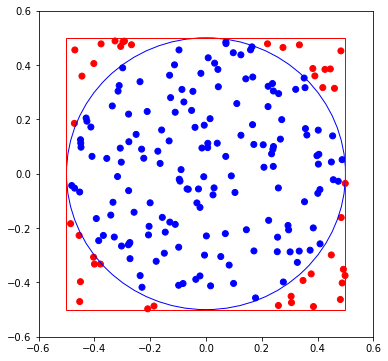

3.16


In [1]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as fig
import matplotlib.patches as pch
import numpy as np

# Draw the Cartesian plane between (-0.6, -0,6) and (0.6, 0.6).
fig = plt.figure(figsize=(6, 6))
axes = fig.add_subplot(1, 1, 1)
axes.set_xlim(-0.6, 0.6)
axes.set_ylim(-0.6, 0.6)

# Center at origin a circle of diameter 1 and a square of area 1.
axes.add_patch(
    plt.Circle(
        (0, 0), radius=0.5, edgecolor='b', facecolor='None'
    )
)
axes.add_patch(
    pch.Rectangle(
        (-0.5, -0.5), 1, 1, edgecolor='r', facecolor='None'
    )
)

# Add random points and color them blue if they are in the circle.
n = 200
(x, y) = (-0.5 + np.random.rand(n), -0.5 + np.random.rand(n))
colors = ['b' if (x[i]**2 + y[i]**2 <= 0.5**2) else 'r' for i in range(n)]
plt.scatter(x, y, c=colors)

# Show the plot and the fraction of points inside the circle.
plt.show()
print(4 * colors.count('b') / len(colors))

To implement the same workflow using map and reduce operations, it is necessary to split the problem into two parts: (1) a step in which there is no dependency between the entries (*i.e.*, points) in the data, and (2) a step during which these entries need to be combined into a final result.

One approach that can make a MapReduce-like workflow concise to implement is to ensure that the *representation* of a data entry and a partially aggregated set of entries is always the same. This makes it possible to have just a single function that can always take two partial results and combine in into a new, larger partial result. In this example, the representation reflects the final goal: a count of points that are *in* the circle and a count of all the points in the square that have been generated so far.

In [1]:
{
    "circle": 314, 
    "square": 400
}

{'circle': 314, 'square': 400}

The initial data entries are now just a special case of the above: a point inside the circle is represented as `{"circle":1, "square":1}` and a point outside the circle is represented as `{"circle":0, "square":1}`. You can now implement the function `trial` below that corresponds to the map step of the MapReduce-like workflow.

In [1]:
def trial(instance):
    from random import random
    (x, y) = (-0.5 + random(), -0.5 + random())
    return {
        "circle": 1 if (x**2 + y**2 <= 0.5**2) else 0, 
        "square": 1
      }

The function `combine` for the second step is now even simpler to implement. All you need is a function that combines two aggregated estimates into a new aggregated estimate.

In [1]:
def combine(estimate_a, estimate_b):
    return {
        "circle": estimate_a["circle"] + estimate_b["circle"], 
        "square": estimate_a["square"] + estimate_b["square"]
    }

Using the `trial` and `combine` functions to implement a MapReduce-like workflow is then straightforward.

In [1]:
from functools import reduce
estimate = reduce(combine, map(trial, range(4000)))
print(estimate)
print(4 * (estimate["circle"] / estimate["square"]))

{'circle': 3153, 'square': 4000}
3.153


## Partial Application of Functions

A brief digression to review higher-order functions (something covered in a [previous article on decorators](https://python.supply/higher-order-functions-and-decorators)) will be useful for subsequent examples. Given a function that takes more than one argument, it is possible to turn that into a function that takes only the first argument and returns a new function that takes the rest of the arguments as inputs. As an example, consider the following addition function.

In [1]:
def add(x, y):
    return x + y

The following higher-order function can be used to transform it into a function that returns a function.

In [1]:
def partial_(f, x):
    def g(y):
        return f(x, y)
    return g

The example below illustrates how `partial_` works.

In [1]:
add_ = partial_(add, 2)
add_(3)

5

Python has a function [`partial`](https://docs.python.org/3/library/functools.html#functools.partial) in the built-in [functools](https://docs.python.org/3/library/functools.html) library that does exactly what `partial_` does in the above example.

In [1]:
from functools import partial
add_ = partial(add, 2)
add_(3)

5

This is actually a special case of [currying](https://en.wikipedia.org/wiki/Currying), a topic that is usually covered in materials on the functional programming paradigm and associated techniques.

## Multiprocessing

Python's built-in [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) library allows programmers to run multiple processes in parallel if the operating system and hardware support it.

Throughout the rest of this article, an auxiliary function is used that makes it easier to run the multiprocessing library within Jupyter Notebook. This function is a [decorator](https://python.supply/higher-order-functions-and-decorators) that stores the decorated function definition in a temporary module file so that the the multiprocessing library can load it.

In [1]:
def module(function):
    import os
    import importlib
    import uuid
    import inspect

    directory = '/tmp/' + __name__ + '/'
    module_name = 'tmp.' + __name__ + '.' + function.__name__
    
    if not os.path.exists('.' + directory):
        os.makedirs('.' + directory)

    filepath = '.' + directory + '/' + function.__name__ + ".py"
    with open(filepath, "w") as file:
        definition = inspect.getsource(function)
        lines = definition.split("\n")
        if lines[0] == "@module":
            definition = "\n".join(lines[1:])
        file.write(definition)

    module = importlib.import_module(module_name, package=function.__name__)
    return getattr(module, function.__name__)

One of the simplest ways to use the multiprocessing library is to create a pool of processes and to instruct all the processes in that pool execute the same function.

In [1]:
@module
def double(x):
    return x + x

import multiprocessing as mp
with mp.Pool(processes = mp.cpu_count()) as pool:
    ys = pool.map(double, [1, 2, 3, 4])
    print(ys)

[2, 4, 6, 8]


As you can see, the API is already fairly close to a MapReduce-like workflow. However, the workflow for approximating $\pi$ (which is representative of other MapReduce-like workflows) requires that a single aggregated result value is computed at the end.

One way to proceed is to split the point generation portion of the workflow across multiple processes, with each process computing its own estimate iteratively for its subset of the total number of trials. Once all the processes compute their individual estimates, the *reduce* portion of the workflow is split into two parts:

* each process applies `reduce` to compute a single estimate for that process, and
* a global `reduce` operation is applied across all the estimates returned by all the processes.

An implementation of the functions that enable this approach is presented below.

In [1]:
@module
def trial(instance):
    from random import random
    (x, y) = (-0.5 + random(), -0.5 + random())
    return {
        "circle": 1 if (x**2 + y**2 <= 0.5**2) else 0, 
        "square": 1
      }

@module
def combine(estimate_a, estimate_b):
    return {
        "circle": estimate_a["circle"] + estimate_b["circle"], 
        "square": estimate_a["square"] + estimate_b["square"]
    }

These functions can then be used in the following way:

* use the [parts](https://pypi.org/project/parts/) library to split a range of integers `range(10000)` representing the number of single-point trials to run into a number of portions `mp.cpu_count()` corresponding to the number of processes that can be executed in parallel by the host environment;
* for each range of integers, have each process handling its range apply `partial(map, trial)` to its list (which effectively maps `trial` across the list of integers available to that process and yields a list of estimates within that process);
* once all processes finish creating their respective estimate lists (yielding a *list of lists* `es_per_process`), run another process for each estimate list in `es_per_process` that combines that list into a single combined estimate (each process does this by applying the function `partial(reduce, combine)` to its list of estimates); and
* combine all the individual estimates returned by the processes into a single estimate using `reduce(combine, ...)`. 

The code block below implements this approach and outputs the resulting overall estimate.

In [1]:
from functools import partial, reduce
from parts import parts

with mp.Pool(processes = mp.cpu_count()) as pool:
    es_per_process = pool.map(
        partial(map, trial),
        parts(range(10000), pool._processes)
    )
    e = reduce(
        combine,
        pool.map(partial(reduce, combine), es_per_process)
    )
    print(4*(e["circle"] / e["square"]))

3.1452


The [mr4mp](https://pypi.org/project/mr4mp/) library provides a thin wrapper API around the multiprocessing library to enable even more concise implementations of MapReduce-like workflows. Assuming the `trial` and `combine` functions have already been defined, the entire workflow can be implemented using just a few lines of code.

In [1]:
import mr4mp

e = mr4mp.pool().mapreduce(trial, combine, range(10000))
print(4 * (e["circle"] / e["square"]))

3.1472


## Further Reading

This article provides a template illustrating how certain workflows that are compatible with the MapReduce paradigm can be implemented to leverage multiprocessing in an extremely concise way without introducing unnecessary data or control flow dependencies and without requiring any explicit effort to achieve synchronization. Another common MapReduce use case involving a word-document index is [presented in the README](https://github.com/lapets/mr4mp#word-document-index) for the [mr4mp](https://pypi.org/project/mr4mp/) library.

You can visit the [Python Wiki](https://wiki.python.org/moin/ParallelProcessing) to explore the rich ecosystem of other libraries that leverage either the existing multiprocessing support within Python or provide a similar API for other parallel and distributed computing infrastructures. One library that you might consider investigating if you want to use Python to leverage the full power of contemporary distributed programming paradigms and infrastructures (including MapReduce and beyond) is [PySpark](https://pypi.org/project/pyspark/).